In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from datetime import timedelta

In [2]:
%matplotlib inline

In [3]:
data_dir = "data/hsalinarum/beer_et_al_2014/"
plates = os.listdir(data_dir)
plates.remove('temp')
plates = [p for p in plates if not "." in p]
plates

['201201311KB',
 '201112091KB',
 '201201241KB',
 '201112092KB',
 '201112202KB',
 '201112201KB',
 '201201101KB']

In [4]:
combined = pd.DataFrame()
key = pd.DataFrame()
data = pd.DataFrame()

for p in plates:
    files = os.listdir(os.path.join(data_dir,p))
    
    database = pd.read_csv(os.path.join(data_dir,p,"DatabaseKB"+p[:-2]+".txt"))
    if database.shape[1] == 1:
        database = pd.read_csv(os.path.join(data_dir,p,"DatabaseKB"+p[:-2]+".txt"),sep="\t")
    database['plate'] = p
    
    result = pd.read_csv(os.path.join(data_dir,p,"ResultsKB"+p[:-2]+".csv"),index_col=False)
    
    # if there is an unnamed index before time column, delete it
    if result.columns[0] != 'Time':
        del result[result.columns[0]]
        
    result.columns = ['Time'] + result.columns[1:].str.extract("Well[ .]?([0-9]*)").tolist()
        
    # convert times to hour values using the timedelta fxn
    tdelt = result.Time.str.split(":").apply(lambda x: timedelta(hours=int(x[0]), minutes=int(x[1]), seconds=int(x[2])))
    tdelt = tdelt - tdelt.values[0]
    tdelt = tdelt/np.timedelta64(1,'h') # convert to hours
    tdelt = tdelt.round(1)
    result['Time'] = tdelt
    
    # merge results and database
    database['Well'] = result.columns[1:]
    merged = pd.merge(database,result.iloc[:,1:].T,left_on='Well',right_index=True)
    merged.columns = merged.columns[:database.shape[1]].tolist() + result.Time.tolist()
    
    merged.to_csv(os.path.join(data_dir,p+'_merged.csv'),index=False)
    result.to_csv(os.path.join(data_dir,p+'_data.csv'),index=False)
    database.to_csv(os.path.join(data_dir,p+'_design.csv'),index=False)
    
    if combined.shape[0]==0:
        combined = merged
        key = database
        data = result
    else:
        combined = combined.append(merged)
        key = key.append(database)
        
        result.index = range(data.shape[0],data.shape[0]+result.shape[0])
        data = data.append(result)
    print p,data.shape, key.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


201201311KB (381, 201) (200, 29)
201112091KB (762, 201) (400, 30)
201201241KB (1143, 201) (600, 30)
201112092KB (1564, 201) (800, 30)
201112202KB (1985, 201) (1000, 30)
201112201KB (2366, 201) (1200, 30)
201201101KB (2747, 201) (1400, 30)


In [5]:
# this is the first column that isn't a data measurement
time_ind = combined.columns.tolist().index('Arg.Concentration')

In [6]:
select = ['Total.Concentration',"NaCl.Concentration","MgSO4.Concentration","KCl.Concentration"]

In [7]:
combined = combined[~combined[select].isnull().any(1)]

In [8]:
combined.iloc[:,:time_ind] = np.log2(combined.iloc[:,:time_ind])

In [9]:
# combined.iloc[:,:time_ind] = (combined.iloc[:,:time_ind].values.T - combined.iloc[:,0].values.T).T

In [10]:
g = combined.groupby(['Total.Concentration',"NaCl.Concentration","MgSO4.Concentration","KCl.Concentration"])

In [11]:
len(g.groups.keys())

75

In [12]:
keys = g.groups.keys()
keys.sort()
keys

[(2.6328, 1.5419999999999998, 0.0, 1.0908),
 (2.6328, 1.5419999999999998, 0.2724, 0.8184),
 (2.6328, 1.5419999999999998, 0.5454, 0.5454),
 (2.6328, 1.5419999999999998, 0.8184, 0.2724),
 (2.6328, 1.5419999999999998, 1.0908, 0.0),
 (2.6328, 2.052, 0.0, 0.5808),
 (2.6328, 2.052, 0.1452, 0.4356),
 (2.6328, 2.052, 0.2904, 0.2904),
 (2.6328, 2.052, 0.4356, 0.1452),
 (2.6328, 2.052, 0.5808, 0.0),
 (2.6328, 2.568, 0.0, 0.0648),
 (2.6328, 2.568, 0.0162, 0.0486),
 (2.6328, 2.568, 0.0324, 0.0324),
 (2.6328, 2.568, 0.0486, 0.0162),
 (2.6328, 2.568, 0.0648, 0.0),
 (3.072, 1.8, 0.0, 1.273),
 (3.072, 1.8, 0.318, 0.955),
 (3.072, 1.8, 0.636, 0.636),
 (3.072, 1.8, 0.955, 0.318),
 (3.072, 1.8, 1.273, 0.0),
 (3.072, 2.39, 0.0, 0.6779999999999999),
 (3.072, 2.39, 0.16899999999999998, 0.508),
 (3.072, 2.39, 0.33899999999999997, 0.33899999999999997),
 (3.072, 2.39, 0.508, 0.16899999999999998),
 (3.072, 2.39, 0.6779999999999999, 0.0),
 (3.072, 3.0, 0.0, 0.076),
 (3.072, 3.0, 0.019, 0.057),
 (3.072, 3.0, 0.03

In [13]:
concs = np.unique([k[0] for k in keys])
concs.sort()
concs

array([ 2.6328,  3.072 ,  3.5104,  3.9492,  4.388 ])

In [14]:
composite = g.apply(lambda x: x.loc[x.iloc[:,0]<-1,:].iloc[:,26:time_ind].mean(0))
composite = pd.DataFrame((composite.values.T-composite.values[:,0]).T,index=composite.index,columns=composite.columns)

In [15]:
time = composite.columns.astype(float)
diff = time[1:] - time[:-1]
ind = np.where(diff-.1 < 1e-6)[0]
ind

array([  4,  13,  30,  35,  40,  49,  54,  59,  64,  69,  74,  79,  84,
        89,  94,  99, 104, 109, 112, 115, 120, 125, 130, 133, 136, 139,
       142, 147, 150, 153, 158, 163, 168, 173, 176, 179, 182, 185, 188,
       191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227,
       230, 233, 236, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266,
       269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305,
       308, 311, 314, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344,
       347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383,
       386, 389, 392, 395, 398, 401, 404, 407, 410, 413, 416, 419, 422,
       425, 428, 431, 434, 437, 440, 443, 446, 449, 452, 455, 458, 461,
       464, 467, 470, 473, 476, 479, 482, 485, 488, 491, 494])

In [16]:
time

Float64Index([  6.3,   6.5,   6.8,   7.0,   7.2,   7.3,   7.5,   7.8,   8.0,
                8.3,
              ...
              102.8, 103.0, 103.3, 103.5, 103.8, 104.0, 104.3, 104.5, 104.8,
              105.0],
             dtype='float64', length=537)

In [17]:
for i in ind:
    select = np.where(composite.iloc[:,i+1].isnull())[0]
    composite.iloc[select,i+1] = composite.iloc[select,i]

In [18]:
composite = composite.drop(composite.columns[ind],axis=1)

In [19]:
composite = composite.loc[:,composite.columns <= 95]

In [20]:
temp = np.array(composite.index.tolist())
temp[:,1] = temp[:,1].T/(np.sum(temp[:,1:],1))
temp[:,2] = temp[:,2]/(np.sum(temp[:,2:],1))
temp = temp.round(3)
temp = temp[:,:3]
temp

array([[ 2.633,  0.586,  0.   ],
       [ 2.633,  0.586,  0.25 ],
       [ 2.633,  0.586,  0.5  ],
       [ 2.633,  0.586,  0.75 ],
       [ 2.633,  0.586,  1.   ],
       [ 2.633,  0.779,  0.   ],
       [ 2.633,  0.779,  0.25 ],
       [ 2.633,  0.779,  0.5  ],
       [ 2.633,  0.779,  0.75 ],
       [ 2.633,  0.779,  1.   ],
       [ 2.633,  0.975,  0.   ],
       [ 2.633,  0.975,  0.25 ],
       [ 2.633,  0.975,  0.5  ],
       [ 2.633,  0.975,  0.75 ],
       [ 2.633,  0.975,  1.   ],
       [ 3.072,  0.586,  0.   ],
       [ 3.072,  0.586,  0.25 ],
       [ 3.072,  0.586,  0.5  ],
       [ 3.072,  0.586,  0.75 ],
       [ 3.072,  0.586,  1.   ],
       [ 3.072,  0.779,  0.   ],
       [ 3.072,  0.779,  0.25 ],
       [ 3.072,  0.779,  0.5  ],
       [ 3.072,  0.779,  0.75 ],
       [ 3.072,  0.779,  1.   ],
       [ 3.072,  0.975,  0.   ],
       [ 3.072,  0.975,  0.25 ],
       [ 3.072,  0.975,  0.5  ],
       [ 3.072,  0.975,  0.75 ],
       [ 3.072,  0.975,  1.   ],
       [ 3

In [21]:
composite.index = pd.MultiIndex.from_tuples([tuple(t) for t in temp],names=['total','Na/(Na+Mg+K)','Mg/(Mg+K)'])

In [22]:
composite.to_csv("data/hsalinarum/beer_et_al_2014/composite.csv",index=True)

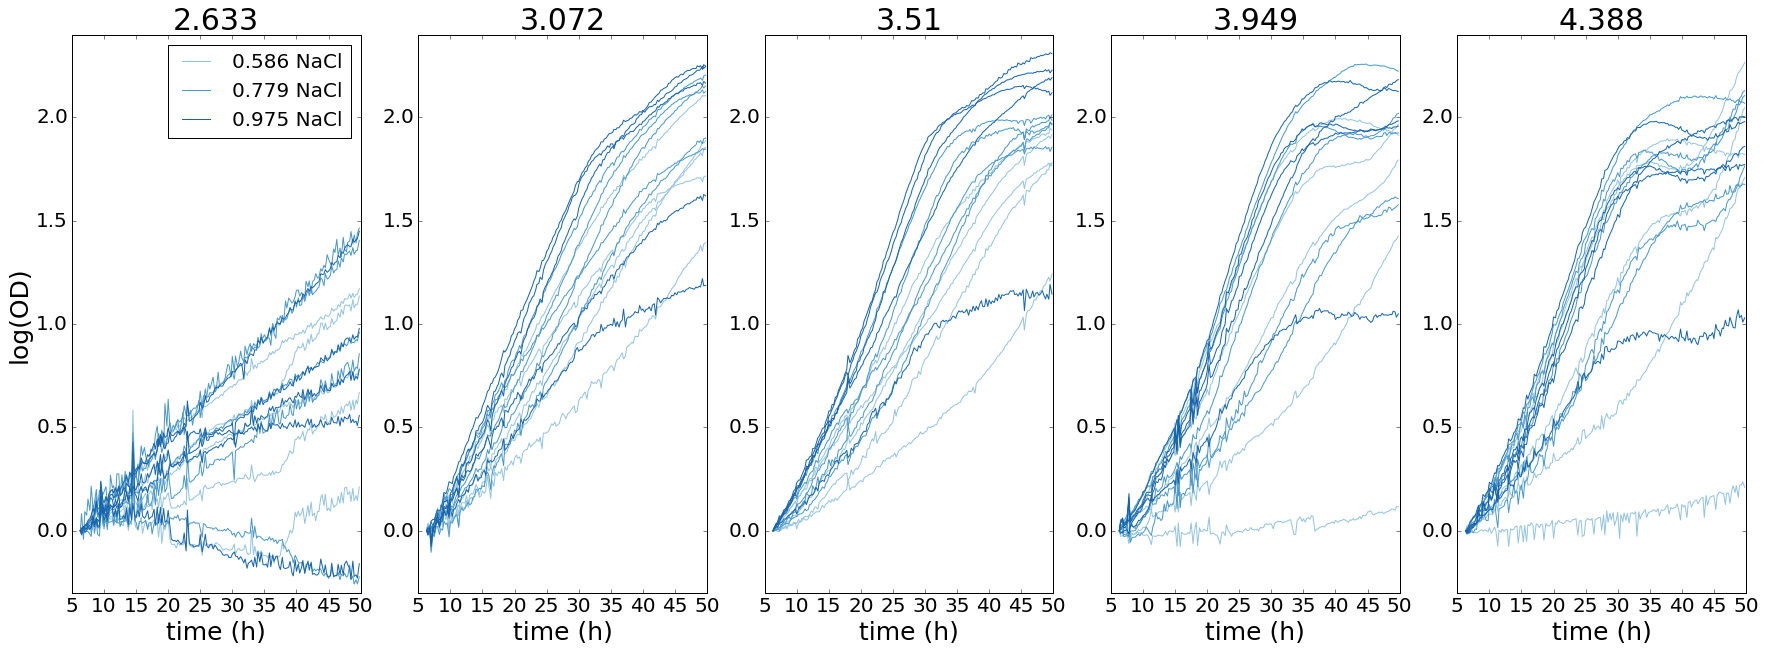

In [74]:
totals = [2.633,3.072,3.51,3.949,4.388]
nacls = [.586,.779,0.975]
labeled={}
r = .4
plt.figure(figsize=(30,10))
select = composite.columns<50
for i in composite.index:
    total,nacl,mg = i
    
    plt.subplot(1,5,totals.index(total)+1)
    plt.title(str(total),fontsize=30)
    
    if total == 2.633 and not nacl in labeled:
        l = str(nacl)+' NaCl'
        labeled[nacl] = None
        plt.plot(composite.columns[select],composite.loc[i,select].values,c=cmap(r+(1.-r)*nacls.index(nacl)/len(nacls)),label=l)
    else:
        plt.plot(composite.columns[select],composite.loc[i,select].values,c=cmap(r+(1.-r)*nacls.index(nacl)/len(nacls)),)
    plt.ylim(-.3,2.4)
    
    
    
plt.subplot(151)
plt.ylabel("log(OD)",fontsize=25)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("time (h)",fontsize=25)


plt.subplot(1,5,1)
plt.legend(loc="best",fontsize=20)

plt.savefig("figures/hsalinarum_sal/nacl_by_total.png",bbox_inches="tight")

In [75]:
composite.head()

6.3       6.5       6.8       7.0       7.3   \
total Na/(Na+Mg+K) Mg/(Mg+K)                                                 
2.633 0.586        0.00        0.0 -0.004794  0.012604  0.009503  0.020643   
                   0.25        0.0  0.007269  0.016409  0.028978  0.028978   
                   0.50        0.0 -0.020211 -0.011695 -0.001522  0.015469   
                   0.75        0.0  0.005727  0.013203  0.018793  0.022570   
                   1.00        0.0 -0.010173  0.004978 -0.000289  0.018543   

                                  7.5       7.8       8.0       8.3   \
total Na/(Na+Mg+K) Mg/(Mg+K)                                           
2.633 0.586        0.00       0.015966  0.009739 -0.010889  0.043989   
                   0.25       0.044874  0.059009  0.060718  0.083231   
                   0.50       0.033188  0.036745  0.031811  0.069680   
                   0.75       0.031821  0.039072  0.042700  0.062597   
                   1.00       0.013395  0.013700 -0.008049  0.020618   

                                  8.5     ...         92.8      93.0  \
total Na/(Na+Mg+K) Mg/(Mg+K)              ...                          
2.633 0.586        0.00       0.025485    ...     0.092956  0.101987   
                   0.25       0.093545    ...     1.691575  1.693828   
                   0.50       0.053420    ...     1.692620  1.694177   
                   0.75       0.077014    ...     1.538274  1.547309   
                   1.00       0.038721    ...     1.088339  1.093074   

                                  93.3      93.5      93.8      94.0  \
total Na/(Na+Mg+K) Mg/(Mg+K)                                           
2.633 0.586        0.00       0.245823  0.344548  0.206066  0.124102   
                   0.25       1.688727  1.698793  1.707845  1.693349   
                   0.50       1.739380  1.759642  1.718287  1.705735   
                   0.75       1.540832  1.549873  1.563370  1.553799   
                   1.00       1.173820  1.205704  1.140244  1.116097   

                                  94.3      94.5      94.8      95.0  
total Na/(Na+Mg+K) Mg/(Mg+K)                                          
2.633 0.586        0.00       0.106138  0.213035  0.185737  0.189655  
                   0.25       1.694478  1.702298  1.705132  1.709599  
                   0.50       1.697380  1.720832  1.717739  1.722404  
                   0.75       1.557731  1.563335  1.566587  1.570382  
                   1.00       1.085886  1.154802  1.147897  1.134850  

[5 rows x 356 columns]

In [117]:
def plot_2d(d1,d2,ylim=None):
    dims = {'total':[2.633,3.072,3.51,3.949,4.388],
            'Na/(Na+Mg+K)':[.586,.779,0.975],
            'Mg/(Mg+K)':[0,.25,.5,.75,1]}
    
    cdim = dims.keys()
    cdim.remove(d1)
    cdim.remove(d2)
    cdim = cdim[0]
    
    select = composite.columns<50
    r = .4
    
    ncols = len(dims[d1])
    nrows = len(dims[d2])
    
    order = [d1,d2,cdim]
    
    for v1 in dims[d1]:
        for v2 in dims[d2]:
            for vc in dims[cdim]:
                pos = dims[d1].index(v1)+len(dims[d1])*dims[d2].index(v2)+1
                plt.subplot(nrows,ncols,pos)
                
                #plt.title("%s=%s, %s=%s"%(d1,str(v1),d2,str(v2)))
                if (pos - 1)%ncols == 0:
                    plt.ylabel("%s=%.2lf"%(d2,v2),rotation=0,fontsize=30)
                if (pos - 1)/ncols == 0:
                    plt.title("%s=%.2lf"%(d1,v1),rotation=0,fontsize=30)
                
                i = v1,v2,vc
                i = [i[order.index(z)] for z in ['total','Na/(Na+Mg+K)','Mg/(Mg+K)']]
                i = tuple(i)
                
                plt.plot(composite.columns[select],composite.loc[i,select].values,c=cmap(r+(1.-r)*dims[cdim].index(vc)/len(dims[cdim])),)            
    
                if not ylim is None:
                    plt.ylim(ylim)
                plt.xticks(fontsize=20)
                plt.yticks(fontsize=20)

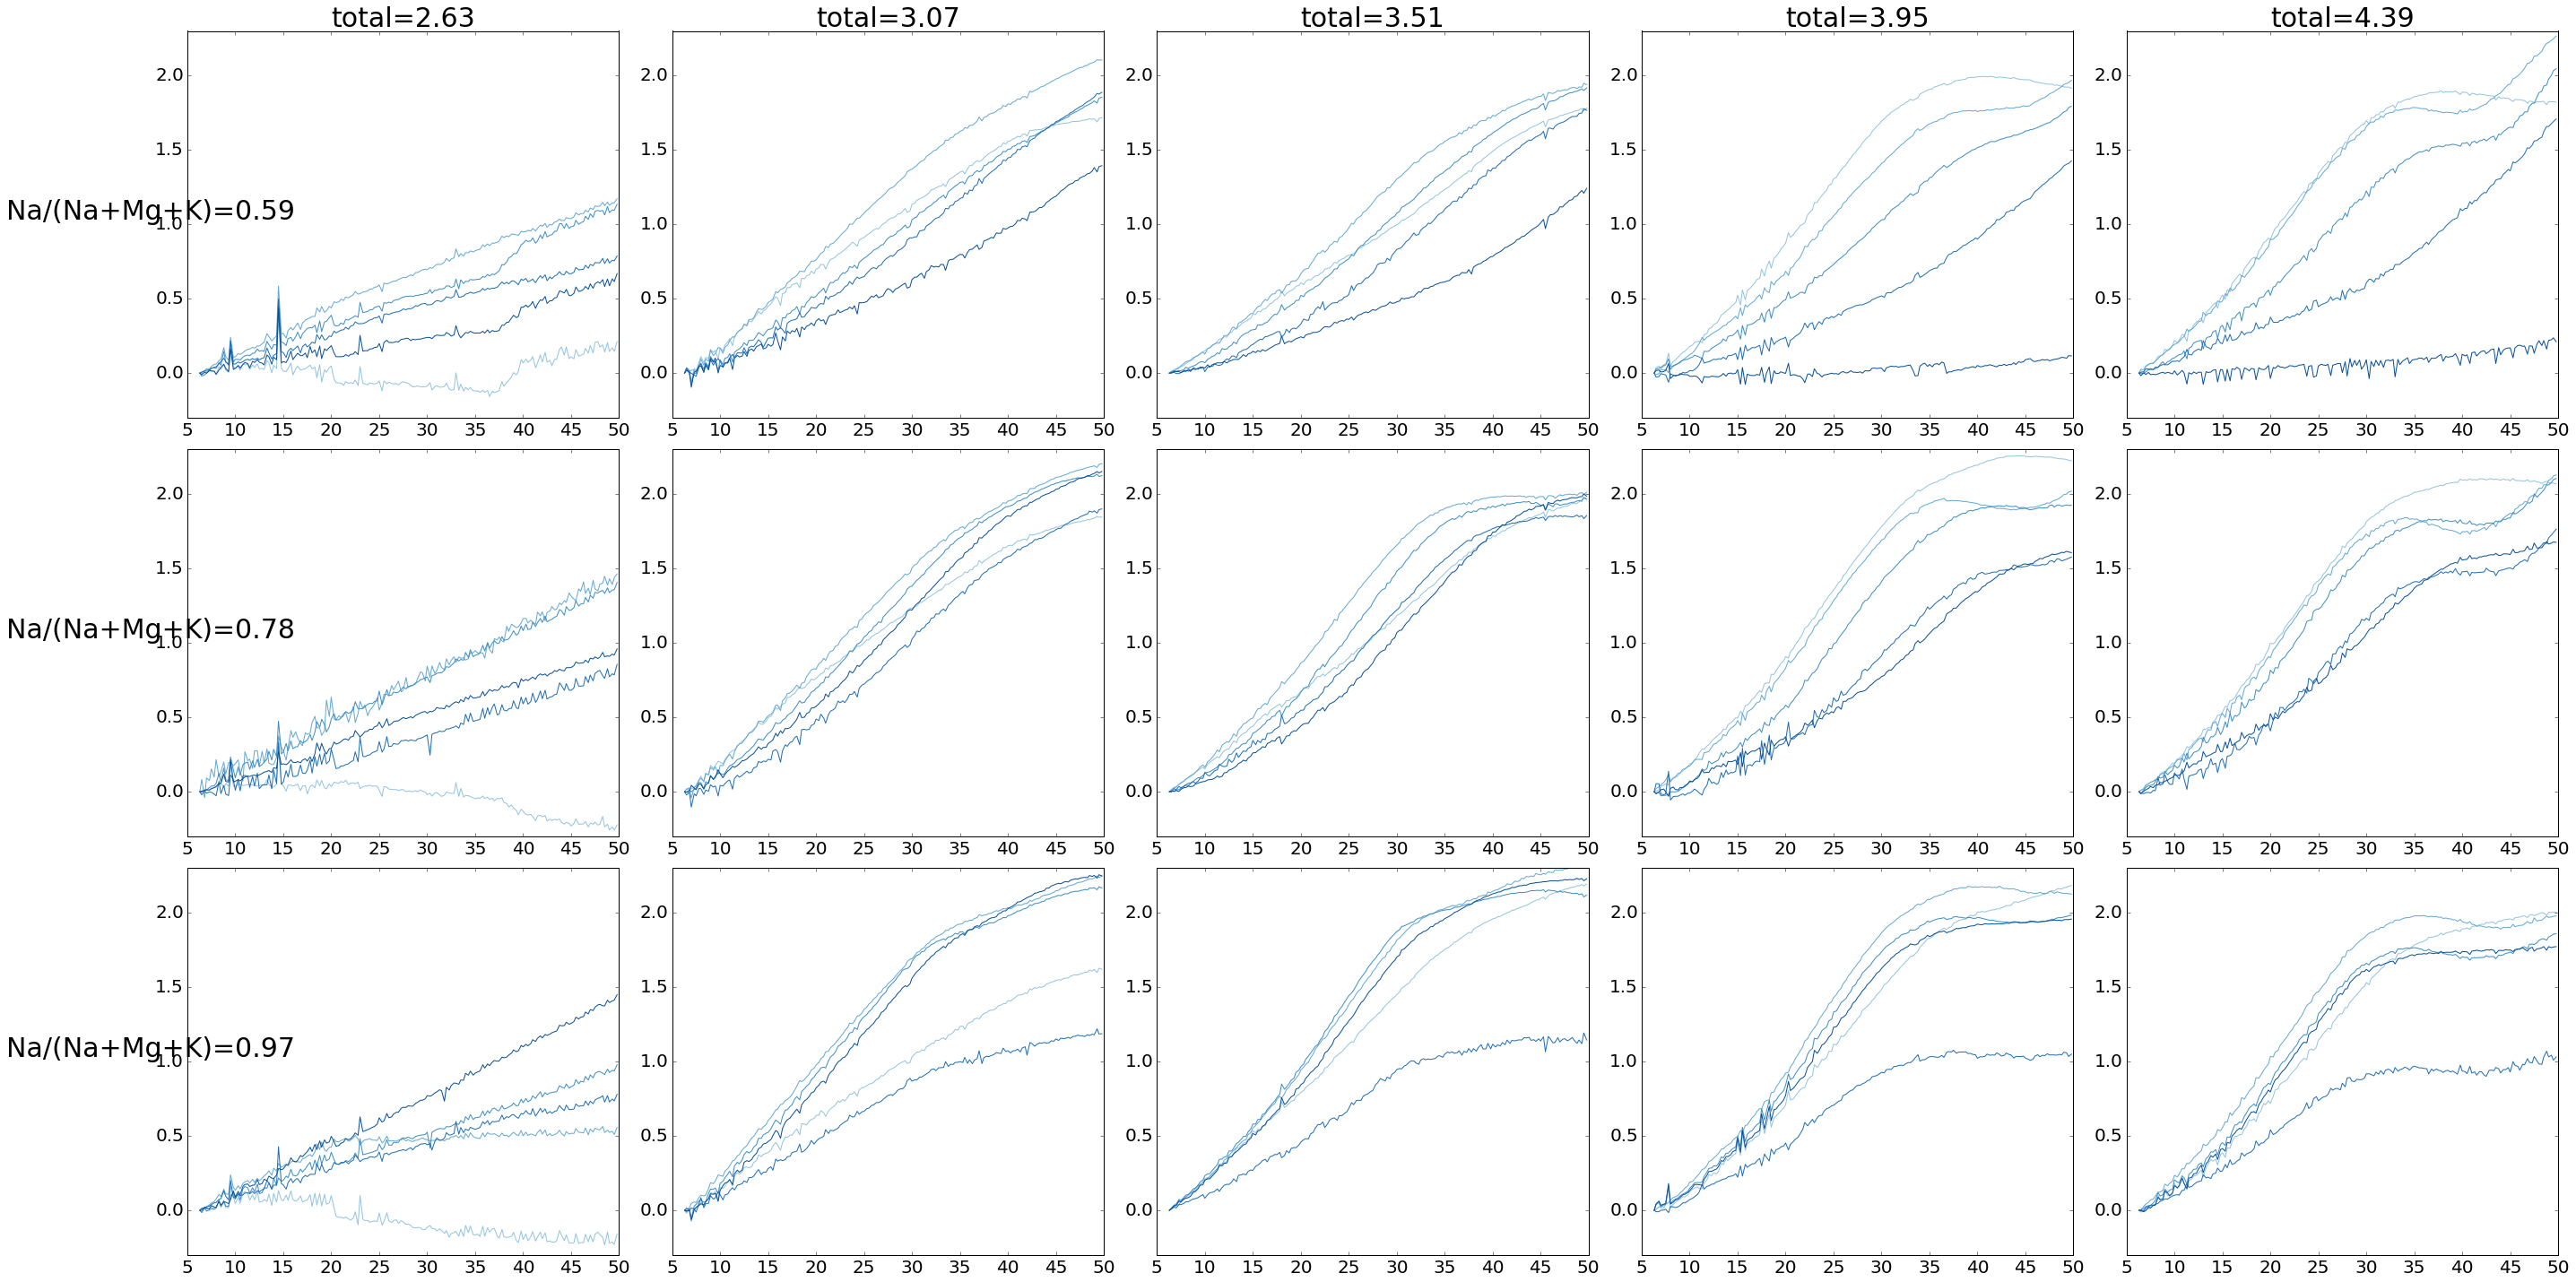

In [118]:
plt.figure(figsize=(40,20))
plot_2d('total','Na/(Na+Mg+K)',(-.3,2.3))
plt.tight_layout()

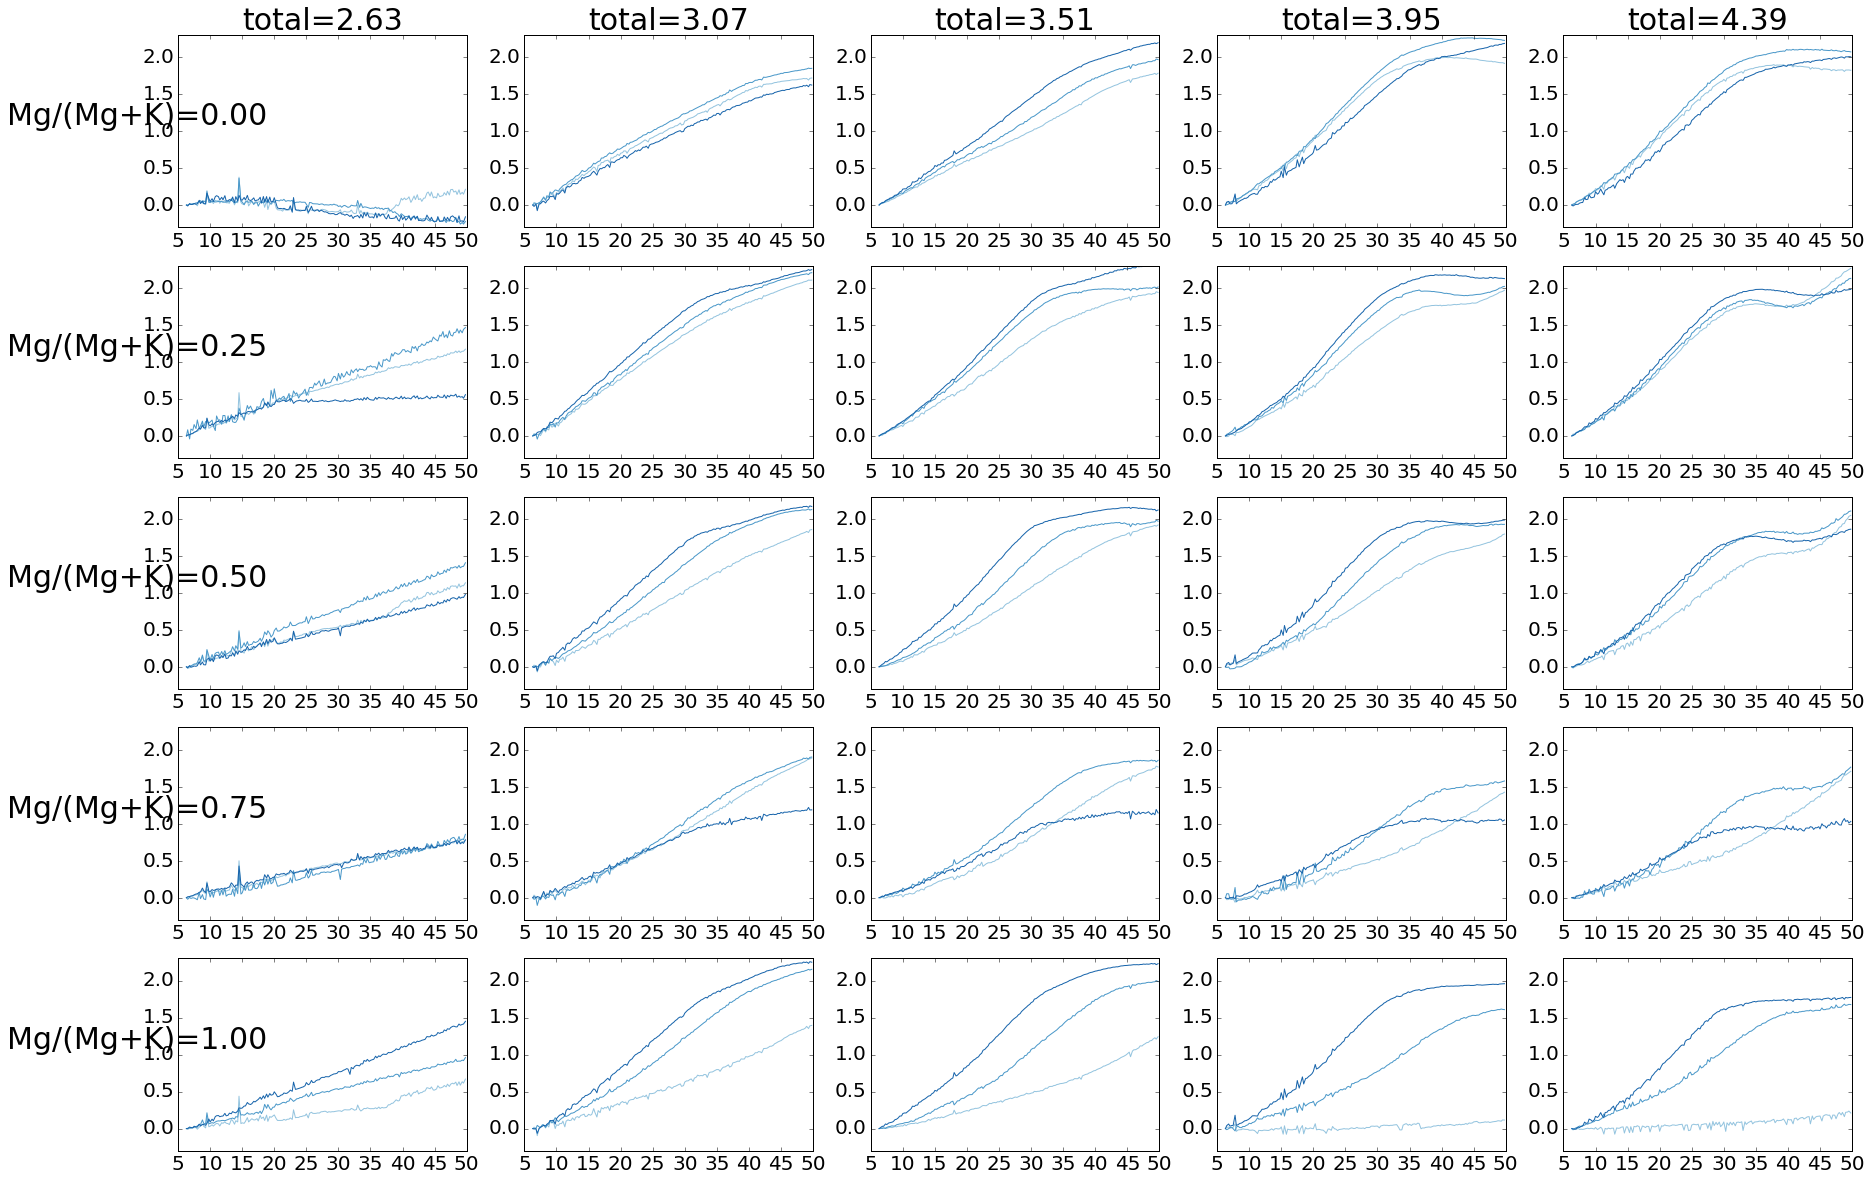

In [121]:
plt.figure(figsize=(30,20))
plot_2d('total','Mg/(Mg+K)',(-.3,2.3))
plt.savefig("figures/hsalinarum_sal/nacl_2d.png",bbox_inches='tight')

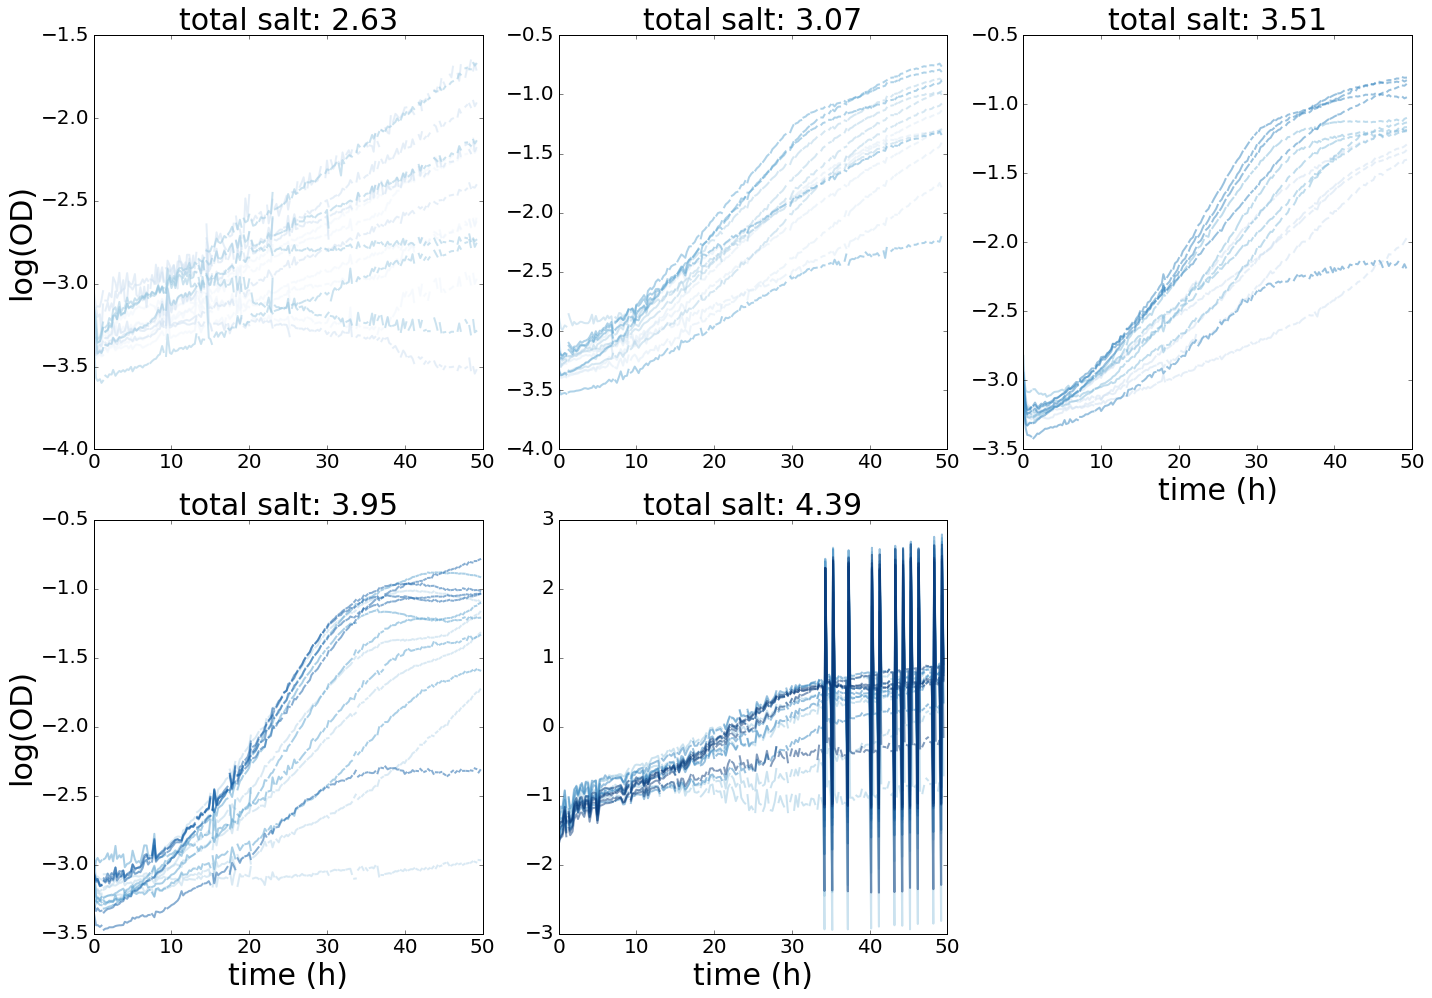

In [28]:
plt.figure(figsize=(20,14))

cmap=plt.get_cmap('Blues')
min_conc = 1.5
max_conc= 4.3
offset = .1

for k in keys:
    i = concs.tolist().index(k[0]) + 1
    plt.subplot(2,3,i)
    
    temp = g.get_group(k)
    time = temp.columns[:time_ind]
    od = temp.iloc[:,:time_ind].mean(0)
    
    # od = od.loc[:,time<50]
    od = od[time<50]
    time = time[time<50]
    
    #od = od.loc[od.iloc[:,0]<-1,:]
#     od = od[od.iloc[0]<-1]
    
#     time = time[~od.isnull()]
#     od = od[~od.isnull()]
    
    plt.plot(time,od.values.T,'-',c=cmap((k[1]-min_conc+offset)/(max_conc-min_conc+2*offset)),label='%.2lf M NaCl'%k[1],lw=2,alpha=.5)
    
for c in concs:
    i = concs.tolist().index(c) + 1
    plt.subplot(2,3,i)
    plt.title("total salt: %.2lf"%c,fontsize=30)
    
#     plt.ylim(-4,-.5)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    if i == 1 or i == 4:
        plt.ylabel("log(OD)",fontsize=30)
    if i>=3:
        plt.xlabel("time (h)",fontsize=30)
    
plt.tight_layout()

plt.savefig("hsalinarum_salinity_bySalt_nacl.png",bbox_inches="tight")

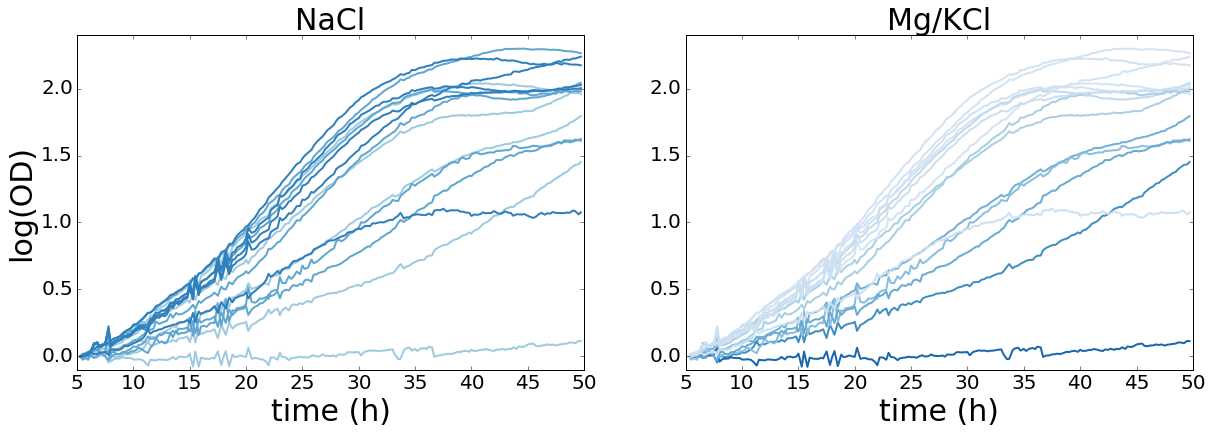

In [31]:
plt.figure(figsize=(20,6))
for k in keys:
    if not k[0] == 3.9492:
        continue
    
    temp = g.get_group(k)
    time = temp.columns[:time_ind]
    od = temp.iloc[:,:time_ind].mean(0)
    
    od = od[time>5]
    time = time[time>5]
    
    od = od[time<50]
    time = time[time<50]
    
    time = time[~od.isnull()]
    od = od[~od.isnull()]
    
    od = od-od.values[0]
    
    plt.subplot(121)
    plt.plot(time,od,'-',c=cmap((k[1]-min_conc+offset)/(max_conc-min_conc+2*offset)),label='%.2lf M NaCl'%k[1],lw=2)
    
    plt.subplot(122)
    plt.plot(time,od,'-',c=cmap((k[2]-0+.5)/(1.7-0+2*.5)),label='%.2lf M Mg'%k[1],lw=2)
    
plt.subplot(121)
plt.title("NaCl",fontsize=30)
plt.ylim(-.1,2.4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("log(OD)",fontsize=30)
plt.xlabel("time (h)",fontsize=30)

plt.subplot(122)
plt.title("Mg/KCl",fontsize=30)
plt.ylim(-.1,2.4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("time (h)",fontsize=30)

plt.savefig("hsalinarum_salinity_single_nacl_mgkcl.png",bbox_inches="tight")

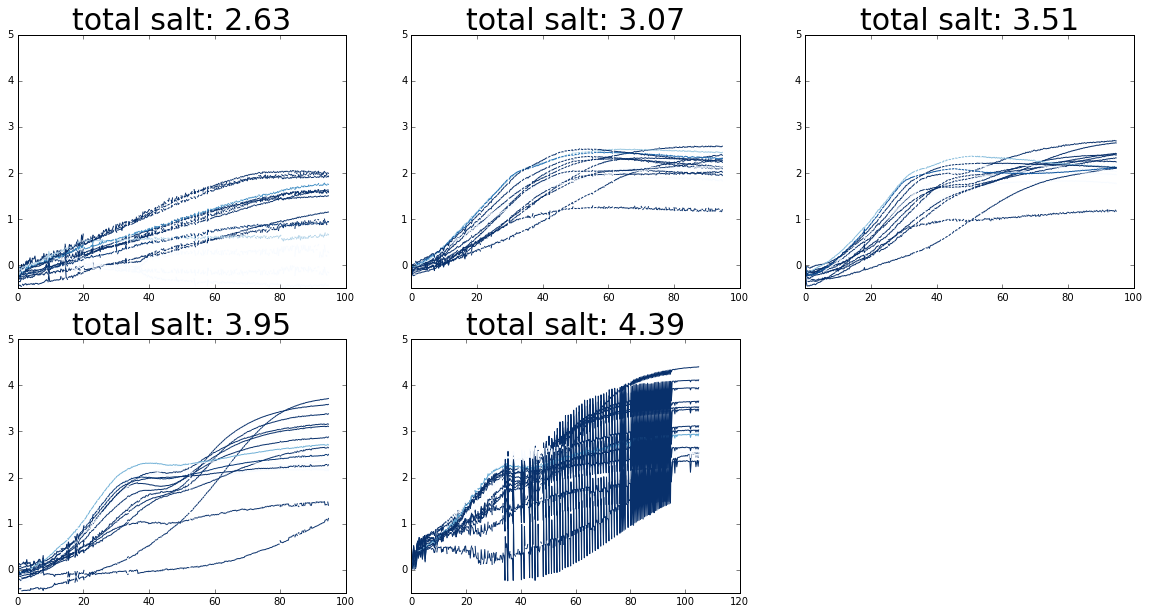

In [18]:
plt.figure(figsize=(20,10))

cmap=plt.get_cmap('Blues')
min_conc = 0
max_conc= .05

for k in keys:
    i = concs.tolist().index(k[0]) + 1
    plt.subplot(2,3,i)
    
    temp = g.get_group(k)
    time = temp.columns[:time_ind]
    od = temp.iloc[:,:time_ind].mean(0)
    plt.plot(time,od,c=cmap((k[2]-min_conc)/(max_conc-min_conc)),label='%.2lf M NaCl'%k[1])
    
for c in concs:
    i = concs.tolist().index(c) + 1
    plt.subplot(2,3,i)
    plt.title("total salt: %.2lf"%c,fontsize=30)
    
    plt.ylim(-.5,5)

# Tidy this shiznit

In [44]:
combined.to_csv("data/hsalinarum/beer_et_al_2014/combined.csv",index=False)

In [110]:
effect = combined[['KCl.Concentration','MgSO4.Concentration','NaCl.Concentration','Total.Concentration']]

effect.columns = effect.columns.str.replace(".","_")
effect.values[:,:3] = (effect.values[:,:3]/effect.Total_Concentration.values[:,None])

effect.loc[:,'KCl_Concentration'] = effect.KCl_Concentration.factorize()[0]
effect.loc[:,'MgSO4_Concentration'] = effect.MgSO4_Concentration.factorize()[0]
effect.loc[:,'NaCl_Concentration'] = effect.NaCl_Concentration.factorize()[0]
effect.loc[:,'Total_Concentration'] = effect.Total_Concentration.factorize()[0]

In [111]:
effect

,KCl_Concentration,MgSO4_Concentration,NaCl_Concentration,Total_Concentration
11,0,0,0,0
12,0,0,0,0
13,0,0,0,0
14,0,0,0,0
15,0,0,0,0
16,0,0,0,0
17,0,0,0,0
18,0,0,0,0
21,1,1,0,0
22,1,1,0,0


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  5,  5,  5,
         5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,
         0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
        12,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,  3,
         3,  3,  3,  3,  3,  3,  3, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,
         0,  0,  0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
         8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  9,  9,  9,  9,  9,
         9, 

In [72]:
import patsy

In [88]:
m = patsy.dmatrix('0+C(KCl_Concentration)+C(MgSO4_Concentration)+C(NaCl_Concentration)+C(Total_Concentration)',effect)
m.shape

(768, 81)

In [87]:
np.array(m)

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  0.]])

In [39]:
time_ind = 563
combined.columns[:time_ind]

Index([  0.0,   0.3,   0.5,   0.8,   1.0,   1.2,   1.3,   1.5,   1.8,   2.0,
       ...
       102.8, 103.0, 103.3, 103.5, 103.8, 104.0, 104.3, 104.5, 104.8, 105.0],
      dtype='object', length=563)

In [43]:
tidy = pd.melt(combined,id_vars=combined.columns[time_ind:].tolist(),
        value_vars=combined.columns[:time_ind].tolist(),
        var_name="time",value_name='od')

tidy.to_csv("data/hsalinarum/beer_et_al_2014/tidy.csv",index=False)

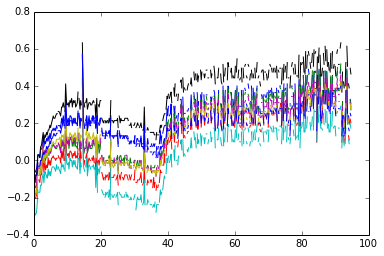

In [231]:
temp = g.get_group(keys[0])
time = temp.columns[:time_ind]
od = temp.iloc[:,:time_ind]
plt.plot(time,od.T)

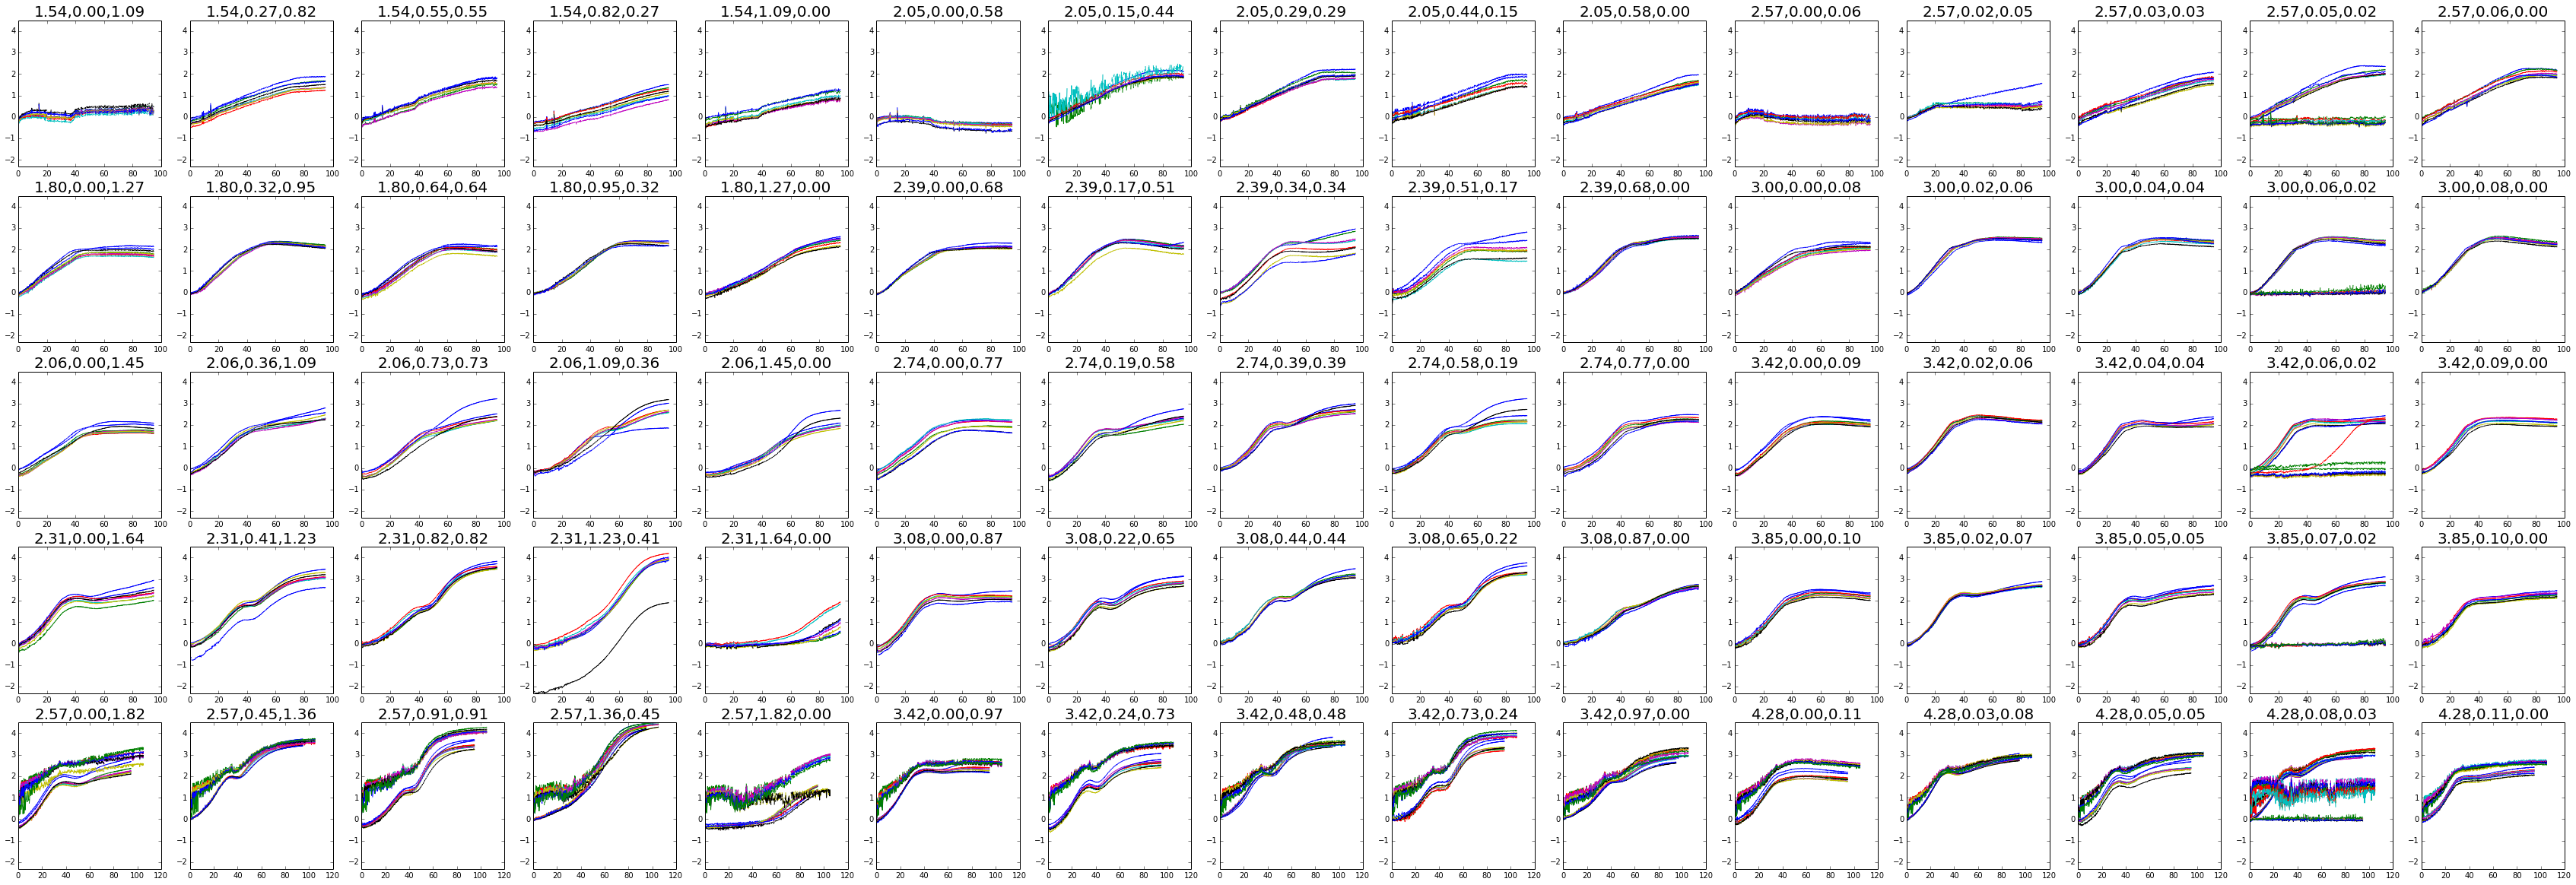

In [232]:
plt.figure(figsize=(60,20))

ylim = (np.inf,-np.inf)

for i,k in enumerate(keys):
    
    plt.subplot(5,15,i+1)
    
    temp = g.get_group(k)
    time = temp.columns[:time_ind]
    od = temp.iloc[:,:time_ind]
    plt.plot(time,od.T)
    
    s = ','.join("%.2lf" % v for v in k[1:])
    
    plt.title(s,fontsize=20)
    
    ylim = (min(od.min().min(),ylim[0]),max(od.max().max(),ylim[1]))
    
    
# standardize ylim for all plots
for i in range(len(keys)):
    plt.subplot(5,15,i+1)
    plt.ylim(ylim)
    
plt.savefig("hsalinarum_salinity_raw_data.pdf",bbox_inches="tight")